In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- PART 1: Goodman & Weare (2010) Stretch Move Sampler (from scratch) ---
# This section implements the ensemble sampler using the stretch move proposed in Goodman & Weare (2010).
# Reference: Goodman & Weare (2010), "Ensemble Samplers with Affine Invariance"

In [3]:
# Target distribution: A 2D Gaussian with strong correlation (banana or stretched shape)
def log_prob(x):
    """Log of a difficult target distribution: a correlated Gaussian."""
    return -((x[0] - x[1])**2 / (2 * 0.01) + (x[0] + x[1])**2 / 2)

In [4]:
def stretch_move(xk, Xj, a=2.0):
    """
    Performs a single stretch move for one walker xk using another walker Xj as a reference.
    """
    n_dim = len(xk)
    z = np.random.uniform(1.0 / a, a)  # scale parameter
    y = Xj + z * (xk - Xj)  # stretch move proposal

    # Acceptance probability as in GW (2010), eq (9)
    log_accept_ratio = (n_dim - 1) * np.log(z) + log_prob(y) - log_prob(xk)
    if np.log(np.random.rand()) < log_accept_ratio:
        return y  # accept
    else:
        return xk  # reject

In [5]:
def run_ensemble_sampler(n_walkers=20, n_dim=2, n_steps=1000, a=2.0):
    """
    Runs the Goodman & Weare affine-invariant ensemble sampler.
    """
    # Initial ensemble: walkers sampled from a wide Gaussian
    ensemble = np.random.randn(n_walkers, n_dim)
    samples = np.zeros((n_steps, n_walkers, n_dim))

    for t in range(n_steps):
        for k in range(n_walkers):
            # Pick a complementary walker j != k
            j = np.random.choice([i for i in range(n_walkers) if i != k])
            ensemble[k] = stretch_move(ensemble[k], ensemble[j], a=a)
        samples[t] = ensemble

    return samples

In [6]:
samples = run_ensemble_sampler()

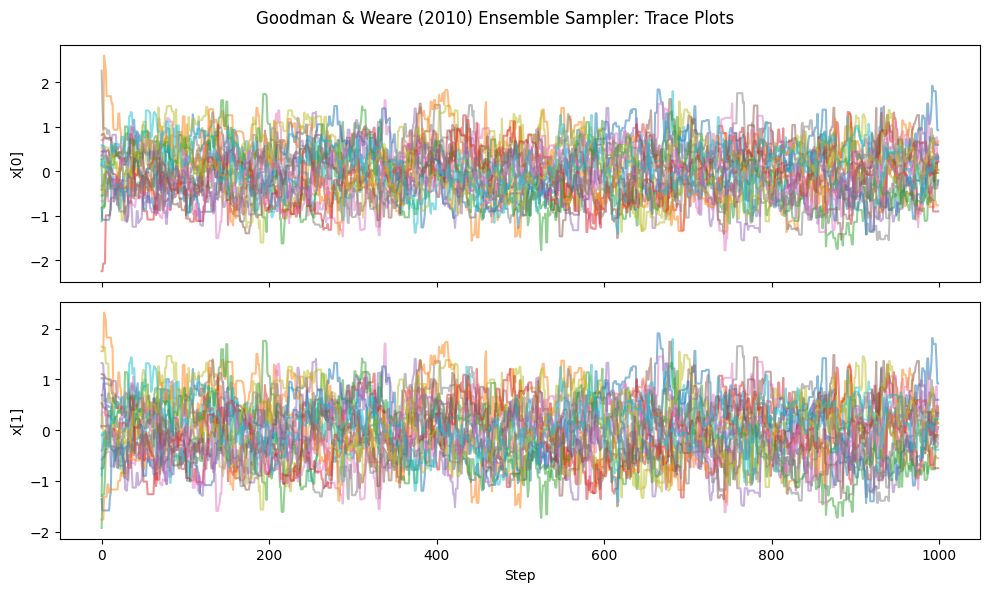

In [7]:
# Show trace plots
fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)
for i in range(samples.shape[1]):
    axs[0].plot(samples[:, i, 0], alpha=0.5)
    axs[1].plot(samples[:, i, 1], alpha=0.5)
axs[0].set_ylabel("x[0]")
axs[1].set_ylabel("x[1]")
axs[1].set_xlabel("Step")
plt.suptitle("Goodman & Weare (2010) Ensemble Sampler: Trace Plots")
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

In [9]:
# --- EXTENSION for Goodman & Weare (2010): Additional Targets and Diagnostics ---

In [10]:
# Target 1: Anisotropic Gaussian (same as before)
def log_prob_anisotropic(x):
    return -((x[0] - x[1])**2 / (2 * 0.01) + (x[0] + x[1])**2 / 2)

In [11]:
# Target 2: Rosenbrock function (banana-shaped)
def log_prob_rosenbrock(x, a=1.0, b=100.0):
    """Log probability of the Rosenbrock function (converted to a negative loss)."""
    return -(b * (x[1] - x[0]**2)**2 + (a - x[0])**2)

In [12]:
# Generic stretch move with arbitrary log_prob
def stretch_move_generic(xk, Xj, log_prob_fn, a=2.0):
    n_dim = len(xk)
    z = np.random.uniform(1.0 / a, a)
    y = Xj + z * (xk - Xj)
    log_accept_ratio = (n_dim - 1) * np.log(z) + log_prob_fn(y) - log_prob_fn(xk)
    if np.log(np.random.rand()) < log_accept_ratio:
        return y
    else:
        return xk

In [13]:
def run_ensemble_sampler_generic(log_prob_fn, n_walkers=20, n_dim=2, n_steps=1000, a=2.0):
    ensemble = np.random.randn(n_walkers, n_dim)
    samples = np.zeros((n_steps, n_walkers, n_dim))
    for t in range(n_steps):
        for k in range(n_walkers):
            j = np.random.choice([i for i in range(n_walkers) if i != k])
            ensemble[k] = stretch_move_generic(ensemble[k], ensemble[j], log_prob_fn, a=a)
        samples[t] = ensemble
    return samples

In [14]:
# Compute autocorrelation time of one walker dimension
def autocorr_time(chain):
    n = len(chain)
    mean = np.mean(chain)
    var = np.var(chain)
    acf = correlate(chain - mean, chain - mean, mode='full')[n-1:] / (var * n)
    return 1 + 2 * np.sum(acf[1:int(n/10)])  # truncate early for faster estimation

In [15]:
# Run on Rosenbrock distribution
import time

start_seq = time.time()
samples_rosen = run_ensemble_sampler_generic(log_prob_rosenbrock, n_walkers=30, n_dim=2, n_steps=1000)
end_seq = time.time()
print(f"Sequential runtime: {end_seq - start_seq:.2f} seconds")

Sequential runtime: 1.28 seconds


In [16]:
# Choose one walker and compute autocorrelation time
chain_x0 = samples_rosen[:, 0, 0]
tau_x0 = autocorr_time(chain_x0)

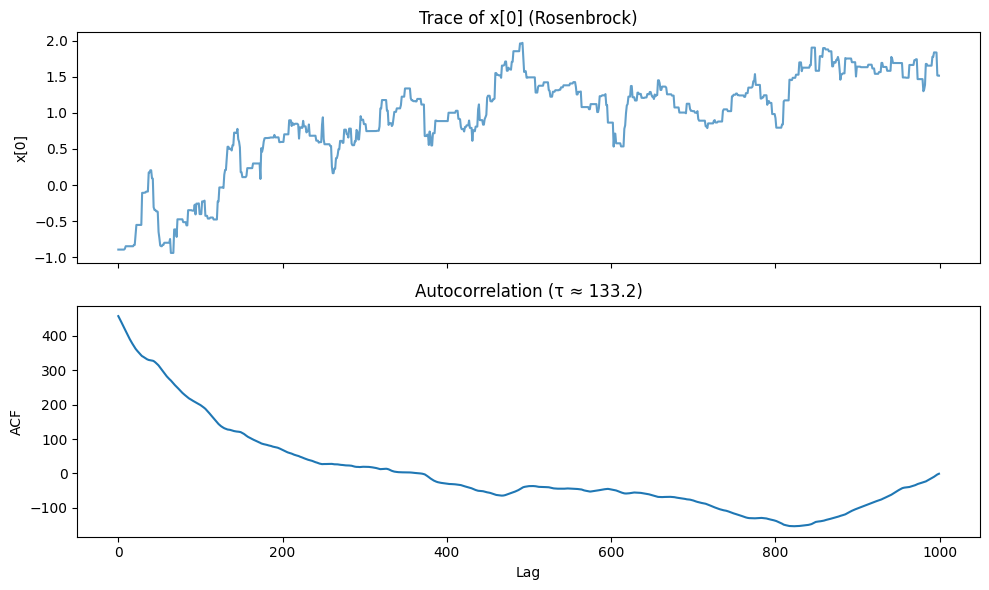

In [17]:
# Plot trace and autocorrelation
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(chain_x0, alpha=0.7)
axs[0].set_title("Trace of x[0] (Rosenbrock)")
axs[1].plot(correlate(chain_x0 - np.mean(chain_x0), chain_x0 - np.mean(chain_x0), mode='full')[len(chain_x0)-1:])
axs[1].set_title(f"Autocorrelation (τ ≈ {tau_x0:.1f})")
axs[0].set_ylabel("x[0]")
axs[1].set_ylabel("ACF")
axs[1].set_xlabel("Lag")
plt.tight_layout()
plt.show()

In [18]:
!pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.7 MB/s eta 0:00:00


In [19]:
import emcee
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# --- PART 2: Foreman-Mackey et al. (2013) emcee package usage ---
# Demonstrates the affine-invariant ensemble sampler using emcee (based on Goodman & Weare)
# Reference: Foreman-Mackey et al. (2013), "emcee: The MCMC Hammer"

In [21]:
# Define the log-probability function (same banana-shaped distribution used in earlier examples)
def log_prob_emcee(x):
    return -((x[0] - x[1])**2 / (2 * 0.01) + (x[0] + x[1])**2 / 2)

In [22]:
# emcee requires a slightly different signature for log_prob:
def log_prob_wrap(x):
    return log_prob_emcee(x)

In [23]:
# Sampler configuration
n_dim = 2
n_walkers = 32
n_steps = 1000

In [24]:
# Initial walker positions: near the origin
initial_state = np.random.randn(n_walkers, n_dim)

In [25]:
# Initialize sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob_wrap)

In [26]:
# Run the MCMC sampler
sampler.run_mcmc(initial_state, n_steps, progress=False)

State([[ 0.50242626  0.5719168 ]
 [-0.30620967 -0.33548146]
 [-0.28390467 -0.17833725]
 [ 0.51917597  0.52385809]
 [-0.04158264  0.03045691]
 [-0.62608319 -0.78931567]
 [-0.511759   -0.55383773]
 [ 0.42062398  0.49711241]
 [ 0.4465859   0.58690599]
 [ 0.48585301  0.4241825 ]
 [ 0.35582664  0.29743458]
 [-0.26892909 -0.1426826 ]
 [-0.2821224  -0.15360768]
 [ 0.40768164  0.64664546]
 [ 0.53323946  0.62196333]
 [-1.07574352 -1.07271948]
 [-0.39319794 -0.31478749]
 [-0.01115713  0.03274815]
 [-0.27053588 -0.19332705]
 [ 0.73598072  0.78191194]
 [ 0.66017089  0.55404285]
 [-0.4361855  -0.36444977]
 [-0.09586254 -0.0347015 ]
 [-0.87871847 -0.9181017 ]
 [ 0.0124749  -0.05917934]
 [-0.45730383 -0.51249673]
 [ 0.71775402  0.59464044]
 [ 0.11686629  0.15114196]
 [-0.22390259 -0.2606217 ]
 [ 0.15420368  0.02937685]
 [ 1.51292157  1.45773639]
 [-0.15142315  0.00764227]], log_prob=[-0.81855324 -0.24872562 -0.66405773 -0.54505613 -0.25954673 -2.33391911
 -0.65627915 -0.71364405 -1.51853903 -0.604244

In [27]:
# Extract the samples: shape (n_steps, n_walkers, n_dim)
samples = sampler.get_chain()

In [28]:
# Compute mean autocorrelation time (Foreman-Mackey et al. use this to measure sampler efficiency)
try:
    tau = sampler.get_autocorr_time()
except:
    tau = np.nan

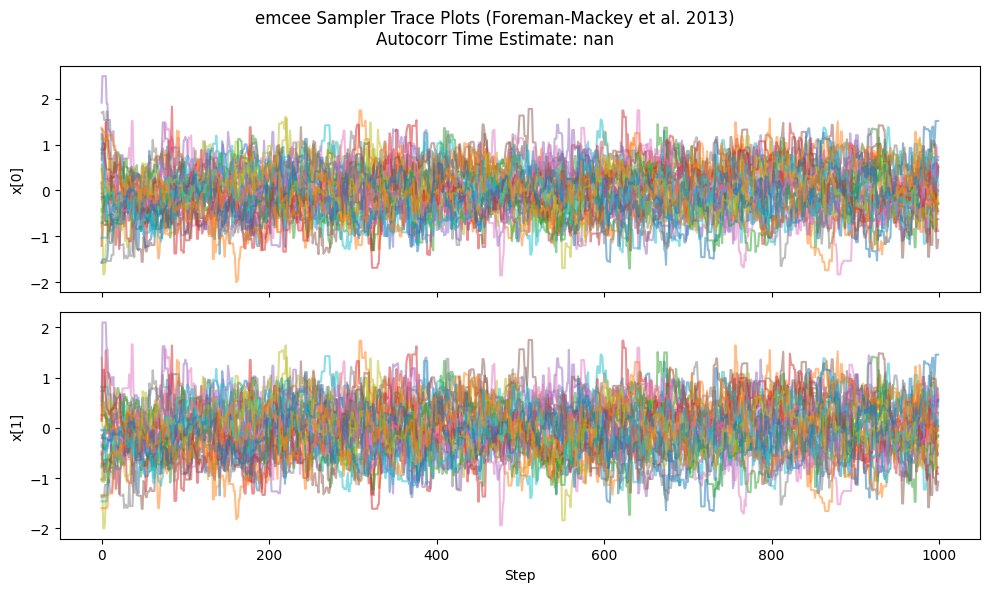

In [29]:
# Plot trace plots
fig, axs = plt.subplots(n_dim, figsize=(10, 6), sharex=True)
for i in range(n_dim):
    for j in range(n_walkers):
        axs[i].plot(samples[:, j, i], alpha=0.5)
    axs[i].set_ylabel(f"x[{i}]")
axs[-1].set_xlabel("Step")
plt.suptitle(f"emcee Sampler Trace Plots (Foreman-Mackey et al. 2013)\nAutocorr Time Estimate: {tau}")
plt.tight_layout()
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

In [31]:
# --- PART 3: Manual Implementation of emcee-style Split Strategy ---
# This mimics the parallel two-group stretch move described in Foreman-Mackey et al. (2013), Section 2

In [32]:
# Log-probability: same banana distribution used previously
def log_prob(x):
    return -((x[0] - x[1])**2 / (2 * 0.01) + (x[0] + x[1])**2 / 2)

In [33]:
def stretch_move_split(xk, Xj, log_prob_fn, a=2.0):
    n_dim = len(xk)
    z = np.random.uniform(1.0 / a, a)
    y = Xj + z * (xk - Xj)
    log_accept_ratio = (n_dim - 1) * np.log(z) + log_prob_fn(y) - log_prob_fn(xk)
    if np.log(np.random.rand()) < log_accept_ratio:
        return y
    else:
        return xk

In [34]:
def run_split_sampler(log_prob_fn, n_walkers=32, n_dim=2, n_steps=1000, a=2.0):
    assert n_walkers % 2 == 0, "n_walkers must be even for splitting"
    ensemble = np.random.randn(n_walkers, n_dim)
    samples = np.zeros((n_steps, n_walkers, n_dim))
    acceptance = np.zeros((n_steps, n_walkers))

    for t in range(n_steps):
        for group in [0, 1]:
            A = ensemble[group::2]        # walkers to update
            B = ensemble[1 - group::2]    # complementary group
            new_A = np.copy(A)
            for i in range(len(A)):
                j = np.random.randint(0, len(B))
                proposed = stretch_move_split(A[i], B[j], log_prob_fn, a)
                new_A[i] = proposed
                acceptance[t, group + 2*i] = np.any(proposed != A[i])
            ensemble[group::2] = new_A
        samples[t] = ensemble

    return samples, acceptance

In [35]:
samples_split, acceptances = run_split_sampler(log_prob, n_walkers=32, n_dim=2, n_steps=1000)

In [36]:
# Compute average acceptance rate across time and walkers
mean_acceptance = np.mean(acceptances)

In [37]:
# Estimate autocorrelation time for x[0] of walker 0
chain_x0 = samples_split[:, 0, 0]
def autocorr_time(chain):
    n = len(chain)
    var = np.var(chain)
    acf = correlate(chain - np.mean(chain), chain - np.mean(chain), mode='full')[n-1:] / (var * n)
    return 1 + 2 * np.sum(acf[1:int(n/10)])

In [38]:
tau_x0 = autocorr_time(chain_x0)

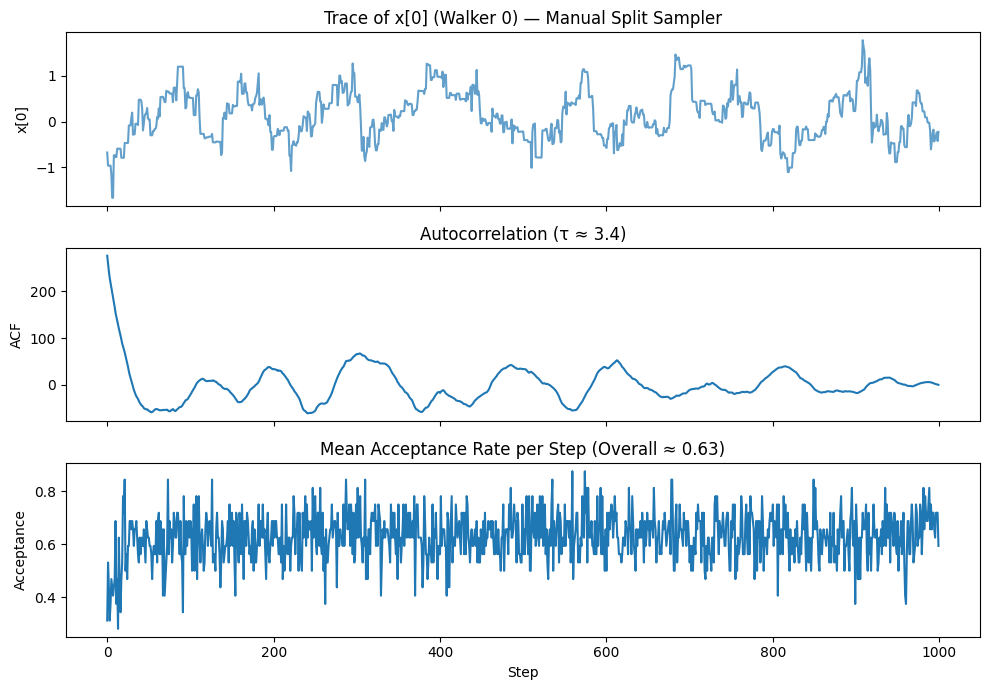

In [39]:
# Plot trace and acceptance
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
axs[0].plot(chain_x0, alpha=0.7)
axs[0].set_title("Trace of x[0] (Walker 0) — Manual Split Sampler")
axs[1].plot(correlate(chain_x0 - np.mean(chain_x0), chain_x0 - np.mean(chain_x0), mode='full')[len(chain_x0)-1:])
axs[1].set_title(f"Autocorrelation (τ ≈ {tau_x0:.1f})")
axs[2].plot(np.mean(acceptances, axis=1))
axs[2].set_title(f"Mean Acceptance Rate per Step (Overall ≈ {mean_acceptance:.2f})")
axs[0].set_ylabel("x[0]")
axs[1].set_ylabel("ACF")
axs[2].set_ylabel("Acceptance")
axs[2].set_xlabel("Step")
plt.tight_layout()
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool

In [41]:
# --- Log-probability function ---
def log_prob(x):
    return -((x[0] - x[1])**2 / (2 * 0.01) + (x[0] + x[1])**2 / 2)

In [42]:
# --- Thread-safe stretch move worker ---
def stretch_move_worker(args):
    xk, Xj, a = args
    n_dim = len(xk)
    z = np.random.uniform(1.0 / a, a)
    y = Xj + z * (xk - Xj)
    log_accept_ratio = (n_dim - 1) * np.log(z) + log_prob(y) - log_prob(xk)
    if np.log(np.random.rand()) < log_accept_ratio:
        return y
    else:
        return xk

In [43]:
# --- Cloud-parallel (threaded) stretch sampler ---
def run_threaded_sampler(log_prob_fn, n_walkers=32, n_dim=2, n_steps=1000, a=2.0, n_cores=4):
    assert n_walkers % 2 == 0, "n_walkers must be even"
    ensemble = np.random.randn(n_walkers, n_dim)
    samples = np.zeros((n_steps, n_walkers, n_dim))

    pool = ThreadPool(processes=n_cores)
    for t in range(n_steps):
        for group in [0, 1]:
            A = ensemble[group::2]
            B = ensemble[1 - group::2]
            args = [(A[i], B[np.random.randint(len(B))], a) for i in range(len(A))]
            new_A = pool.map(stretch_move_worker, args)
            ensemble[group::2] = np.array(new_A)
        samples[t] = ensemble
    pool.close()
    pool.join()
    return samples

In [44]:
# --- Run the threaded cloud-parallel sampler ---
samples_cloud = run_threaded_sampler(log_prob, n_walkers=32, n_dim=2, n_steps=1000, n_cores=4)

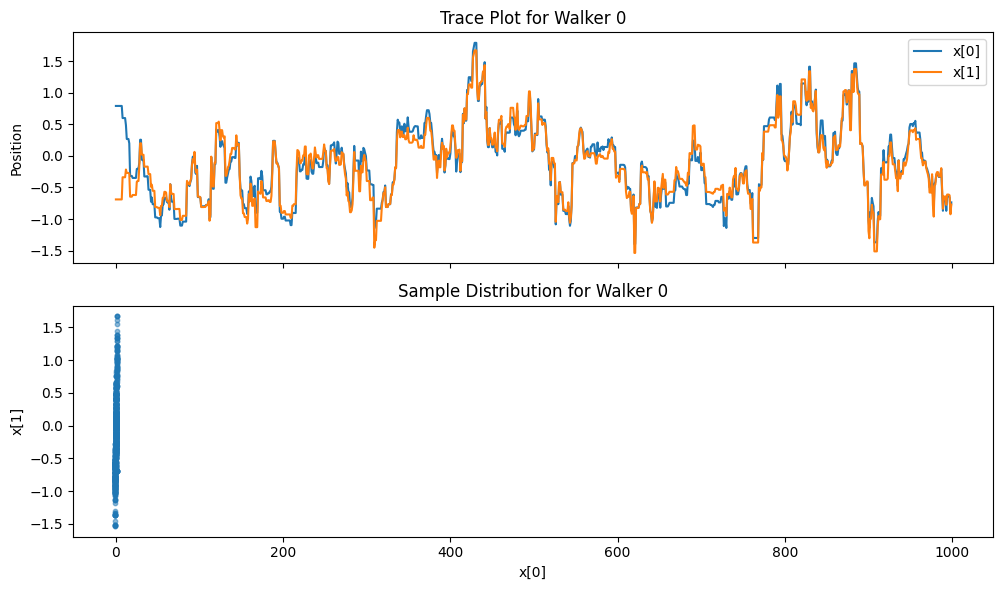

In [45]:
# --- Plot results for Walker 0 ---
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(samples_cloud[:, 0, 0], label="x[0]")
axs[0].plot(samples_cloud[:, 0, 1], label="x[1]")
axs[0].legend()
axs[0].set_ylabel("Position")
axs[0].set_title("Trace Plot for Walker 0")

axs[1].scatter(samples_cloud[:, 0, 0], samples_cloud[:, 0, 1], s=10, alpha=0.5)
axs[1].set_xlabel("x[0]")
axs[1].set_ylabel("x[1]")
axs[1].set_title("Sample Distribution for Walker 0")

plt.tight_layout()
plt.show()

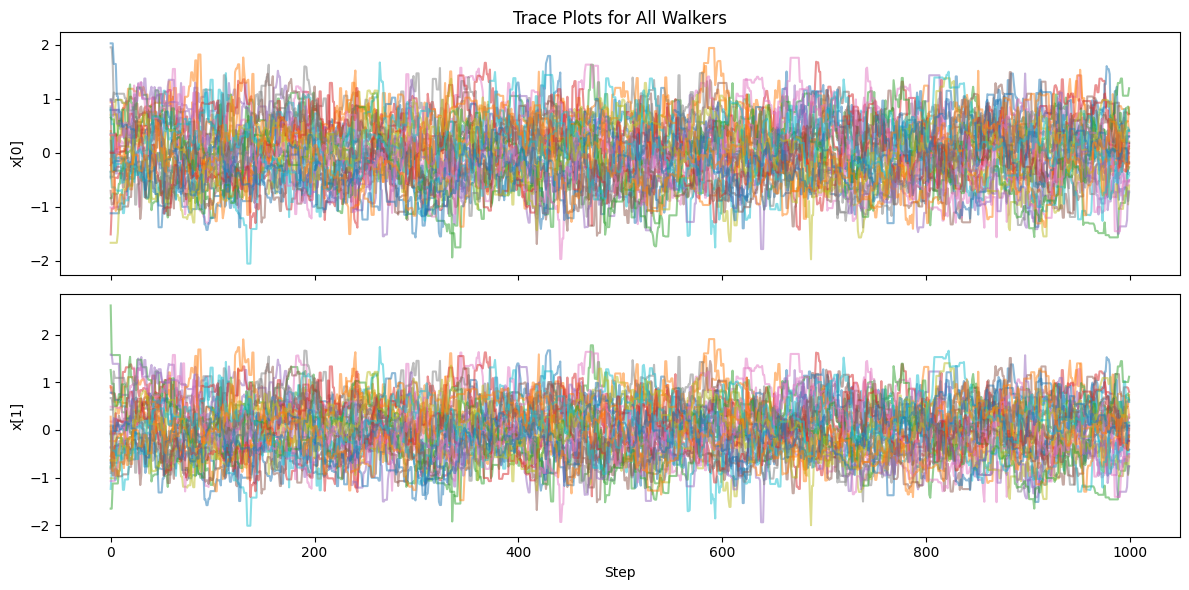

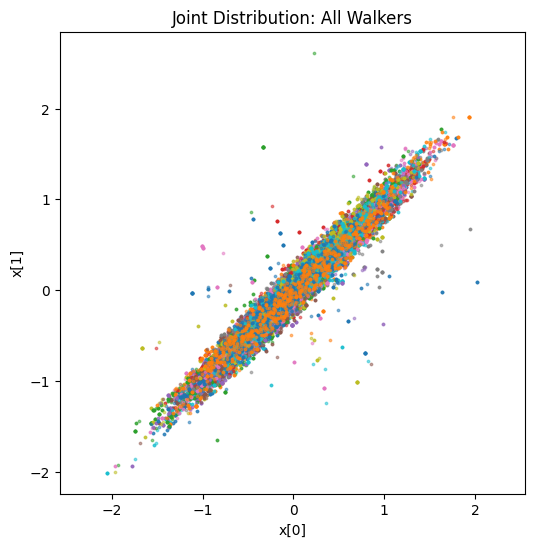

In [46]:
# Plot all walkers' trace plots and joint scatter
import matplotlib.pyplot as plt

n_walkers = samples_cloud.shape[1]

# Trace plots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
for i in range(n_walkers):
    axs[0].plot(samples_cloud[:, i, 0], alpha=0.5)
    axs[1].plot(samples_cloud[:, i, 1], alpha=0.5)
axs[0].set_ylabel("x[0]")
axs[1].set_ylabel("x[1]")
axs[1].set_xlabel("Step")
axs[0].set_title("Trace Plots for All Walkers")
plt.tight_layout()
plt.show()

# Joint distribution
plt.figure(figsize=(6, 6))
for i in range(n_walkers):
    plt.scatter(samples_cloud[:, i, 0], samples_cloud[:, i, 1], s=3, alpha=0.5)
plt.xlabel("x[0]")
plt.ylabel("x[1]")
plt.title("Joint Distribution: All Walkers")
plt.axis("equal")
plt.show()


In [47]:
from scipy.special import expit  # Sigmoid
from sklearn.datasets import make_classification

In [48]:
# Generate toy binary classification data
X_data, y_data = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=42)
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)

In [49]:
# Logistic regression log-likelihood
def log_likelihood_logistic(theta):
    beta = theta[:2]
    bias = theta[2]
    logits = X_data @ beta + bias
    log_lik = np.sum(y_data * logits - np.log1p(np.exp(logits)))
    return log_lik

In [50]:
# Prior: standard normal
def log_prior(theta):
    return -0.5 * np.sum(theta ** 2)

In [51]:
# Posterior
def log_posterior(theta):
    return log_likelihood_logistic(theta) + log_prior(theta)

In [52]:
# Update sampler for logistic regression
samples_logreg = run_threaded_sampler(log_posterior, n_walkers=20, n_dim=3, n_steps=1000, n_cores=4)

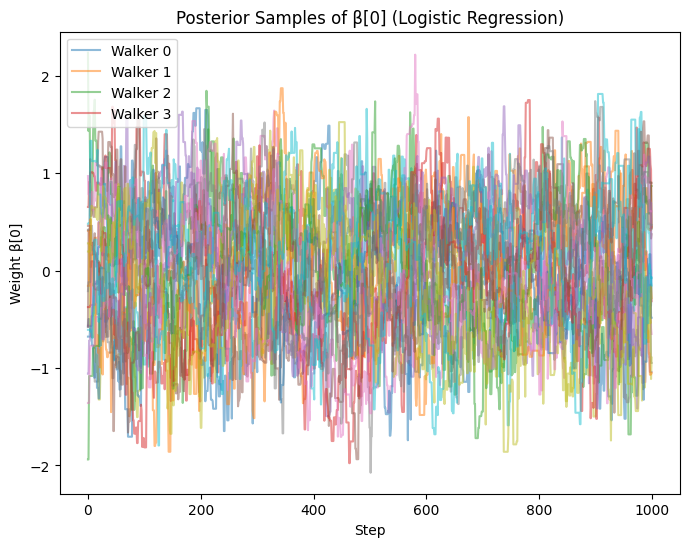

In [53]:
# Plot posterior samples
plt.figure(figsize=(8, 6))
for i in range(samples_logreg.shape[1]):
    plt.plot(samples_logreg[:, i, 0], label=f"Walker {i}" if i < 4 else "", alpha=0.5)
plt.xlabel("Step")
plt.ylabel("Weight β[0]")
plt.title("Posterior Samples of β[0] (Logistic Regression)")
plt.legend()
plt.show()

In [54]:
!pip install -q ray
import ray
ray.init()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 11.6 MB/s eta 0:00:00


2025-05-07 22:42:30,012	INFO worker.py:1888 -- Started a local Ray instance.


Python version:,3.11.11
Ray version:,2.46.0


In [55]:
import numpy as np
from sklearn.datasets import make_classification
from scipy.special import expit  # sigmoid
import matplotlib.pyplot as plt

# Create synthetic binary classification dataset
X_data, y_data = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=42)
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)

def log_likelihood_logistic(theta):
    beta = theta[:2]
    bias = theta[2]
    logits = X_data @ beta + bias
    log_lik = np.sum(y_data * logits - np.log1p(np.exp(logits)))
    return log_lik

def log_prior(theta):
    return -0.5 * np.sum(theta ** 2)

def log_posterior(theta):
    return log_likelihood_logistic(theta) + log_prior(theta)


In [56]:
@ray.remote
def stretch_move_remote(xk, Xj, a=2.0):
    n_dim = len(xk)
    z = np.random.uniform(1.0 / a, a)
    y = Xj + z * (xk - Xj)
    log_accept_ratio = (n_dim - 1) * np.log(z) + log_posterior(y) - log_posterior(xk)
    if np.log(np.random.rand()) < log_accept_ratio:
        return y
    else:
        return xk


In [57]:
def run_ray_sampler(n_walkers=20, n_dim=3, n_steps=500, a=2.0):
    assert n_walkers % 2 == 0
    ensemble = np.random.randn(n_walkers, n_dim)
    samples = np.zeros((n_steps, n_walkers, n_dim))

    for t in range(n_steps):
        for group in [0, 1]:
            A = ensemble[group::2]
            B = ensemble[1 - group::2]
            jobs = []
            for i in range(len(A)):
                Xj = B[np.random.randint(len(B))]
                jobs.append(stretch_move_remote.remote(A[i], Xj, a))
            new_A = ray.get(jobs)
            ensemble[group::2] = np.array(new_A)
        samples[t] = ensemble
    return samples


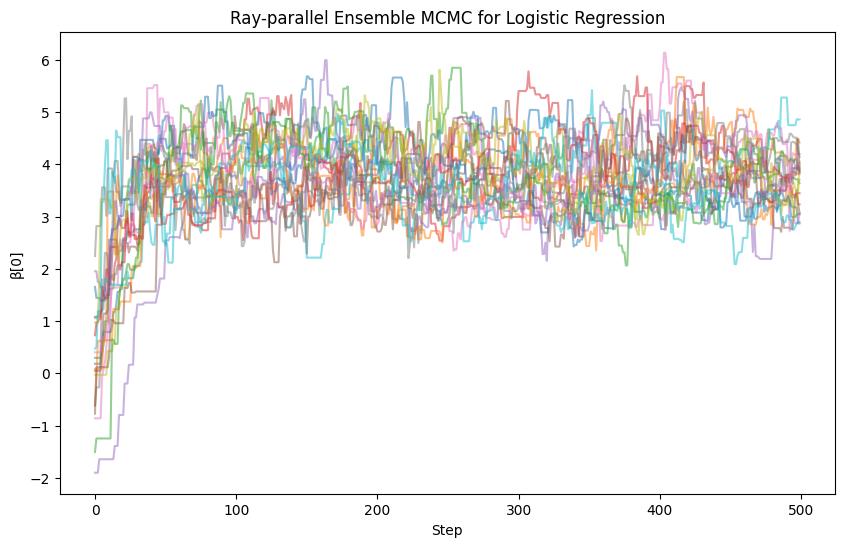

In [58]:
samples_ray = run_ray_sampler()

# Plot trace of beta[0] for all walkers
plt.figure(figsize=(10, 6))
for i in range(samples_ray.shape[1]):
    plt.plot(samples_ray[:, i, 0], alpha=0.5)
plt.xlabel("Step")
plt.ylabel("β[0]")
plt.title("Ray-parallel Ensemble MCMC for Logistic Regression")
plt.show()


In [59]:
!pip install -q ray emcee scikit-learn

In [60]:
import numpy as np
import ray
import emcee
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scipy.special import expit

In [61]:
ray.shutdown()
ray.init(ignore_reinit_error=True)

2025-05-07 22:43:18,464	INFO worker.py:1888 -- Started a local Ray instance.


Python version:,3.11.11
Ray version:,2.46.0


In [62]:
X_data, y_data = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=42)
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)

In [63]:
### 📌 STEP 2: Define Posterior for Logistic Regression
def log_likelihood(theta):
    beta = theta[:2]
    bias = theta[2]
    logits = X_data @ beta + bias
    return np.sum(y_data * logits - np.log1p(np.exp(logits)))

def log_prior(theta):
    return -0.5 * np.sum(theta**2)  # standard normal prior

def log_posterior(theta):
    return log_likelihood(theta) + log_prior(theta)

In [64]:
@ray.remote
def run_emcee_chain(seed=0, n_walkers=50, n_steps=2500, burn_in=200):
    np.random.seed(seed)
    ndim = 3  # 2 features + bias
    p0 = np.random.randn(n_walkers, ndim)
    sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior)

    # Burn-in
    state = sampler.run_mcmc(p0, burn_in, progress=False)
    sampler.reset()

    # Sampling
    sampler.run_mcmc(state, n_steps, progress=False)

    return {
        "chain": sampler.get_chain(),
        "autocorr": sampler.get_autocorr_time(tol=0),
        "acceptance": np.mean(sampler.acceptance_fraction),
        "seed": seed
    }

In [65]:
# Run 4 parallel MCMC chains with different seeds
futures = [run_emcee_chain.remote(seed=i) for i in range(4)]
results = ray.get(futures)

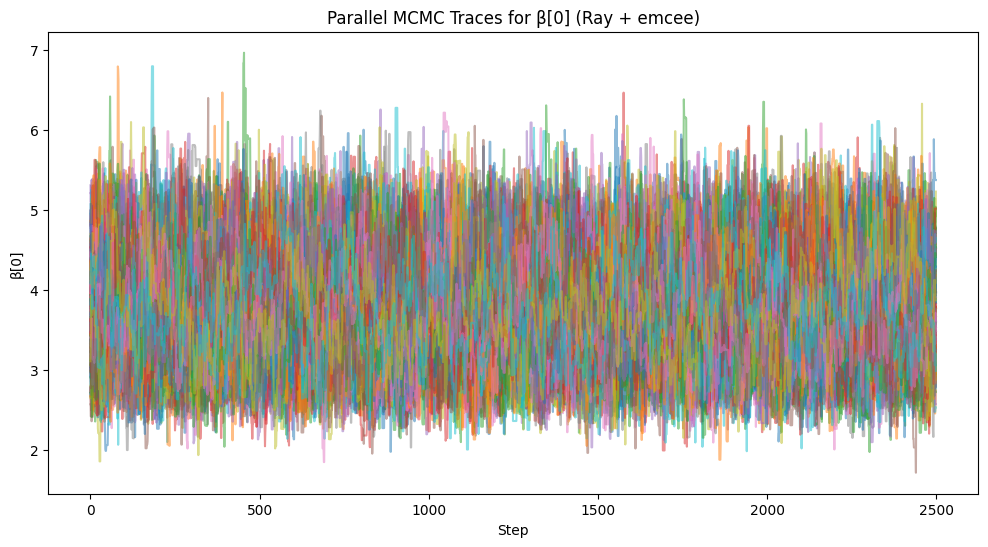

Chain 0 — Seed 0
  Autocorr: [35.56838887 34.67713304 30.16411684]
  Acceptance fraction: 0.646
Chain 1 — Seed 1
  Autocorr: [34.62824307 34.5336189  34.92108033]
  Acceptance fraction: 0.645
Chain 2 — Seed 2
  Autocorr: [38.46674635 34.42330417 38.19959531]
  Acceptance fraction: 0.647
Chain 3 — Seed 3
  Autocorr: [35.42862868 34.7308024  34.26230963]
  Acceptance fraction: 0.644


In [66]:
# Plot β[0] from each chain
plt.figure(figsize=(12, 6))
for i, r in enumerate(results):
    for walker in r['chain'].T[0]:  # Extract β[0] trace from each walker
        plt.plot(walker, alpha=0.5)
plt.xlabel("Step")
plt.ylabel("β[0]")
plt.title("Parallel MCMC Traces for β[0] (Ray + emcee)")
plt.show()

# Print diagnostics
for i, r in enumerate(results):
    print(f"Chain {i} — Seed {r['seed']}")
    print(f"  Autocorr: {r['autocorr']}")
    print(f"  Acceptance fraction: {r['acceptance']:.3f}")

In [67]:
import pickle

# Save chain state
with open("mcmc_results.pkl", "wb") as f:
    pickle.dump(results, f)

In [68]:
# Load later as f: results = pickle.load(f) as:
open("mcmc_results.pkl", "rb")

<_io.BufferedReader name='mcmc_results.pkl'>

In [69]:
!pip install -q corner

In [70]:
import numpy as np

# Stack all chains: shape = (n_chains * n_steps * n_walkers, n_dim)
all_samples = np.vstack([r["chain"].reshape(-1, 3) for r in results])


In [71]:
# Compute mean, std, and 95% credible intervals
param_names = ["β₀", "β₁", "bias"]
for i, name in enumerate(param_names):
    samples_i = all_samples[:, i]
    mean = np.mean(samples_i)
    std = np.std(samples_i)
    ci_lower, ci_upper = np.percentile(samples_i, [2.5, 97.5])
    print(f"{name:>5}: mean = {mean:.3f}, std = {std:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")


   β₀: mean = 3.762, std = 0.556, 95% CI = [2.743, 4.915]
   β₁: mean = -0.859, std = 0.381, 95% CI = [-1.637, -0.143]
 bias: mean = -0.011, std = 0.356, 95% CI = [-0.715, 0.687]


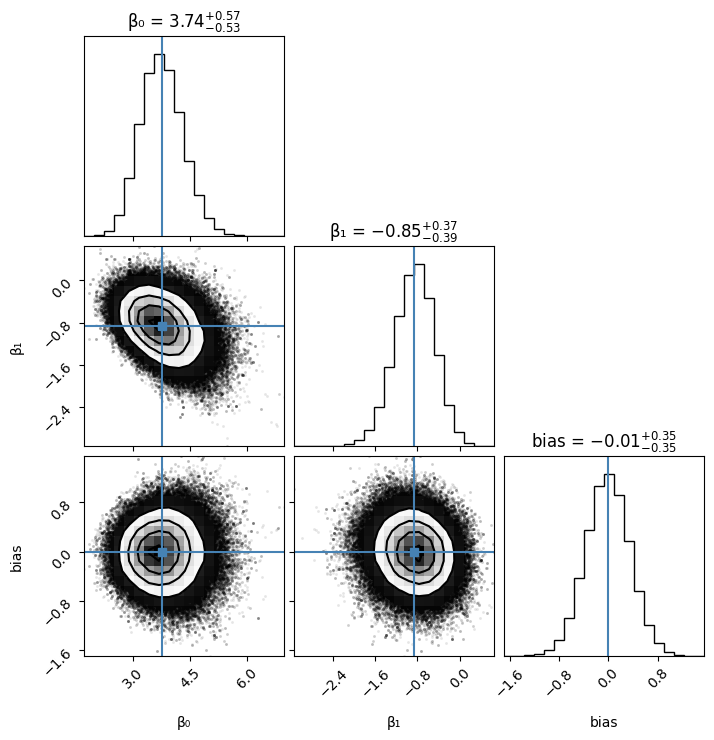

In [72]:
import corner
import matplotlib.pyplot as plt

figure = corner.corner(
    all_samples,
    labels=param_names,
    truths=np.mean(all_samples, axis=0),
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12}
)
plt.show()


In [73]:
from sklearn.metrics import accuracy_score

# Simulate 50 new points (same feature scaling as training)
X_test, y_test = make_classification(n_samples=50, n_features=2, n_redundant=0, random_state=123)
X_test = (X_test - X_data.mean(axis=0)) / X_data.std(axis=0)

# Use 100 random posterior samples
n_draws = 100
posterior_draws = all_samples[np.random.choice(len(all_samples), n_draws, replace=False)]

# Predictive mean classification: average over predictions from each posterior draw
y_preds = []
for theta in posterior_draws:
    beta, bias = theta[:2], theta[2]
    logits = X_test @ beta + bias
    probs = expit(logits)
    y_preds.append(probs > 0.5)

# Average votes over draws
y_pred_mode = np.mean(y_preds, axis=0) > 0.5
acc = accuracy_score(y_test, y_pred_mode)

print(f"Posterior Predictive Accuracy on New Data: {acc:.2f}")


Posterior Predictive Accuracy on New Data: 0.94
